In [1]:
from src.training.model import TransformerClassifier
from src.utils import load_config
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

# Load data

In [49]:
input_dataset = f"../../output_data/{env}/supervised_dataset.parquet"
input_new_class = f"../../output_reports/modelo 1/clustering/new_class.parquet"
input_true_new_class = f"../../output_data/{env}/supervised_dataset_phase2.parquet"

In [50]:
known_classes = pd.read_parquet(input_dataset)
new_class = pd.read_parquet(input_new_class)
true_new_class = pd.read_parquet(input_true_new_class)

In [24]:
features = training_config.training[model_type].features
target = training_config.training[model_type].target

In [25]:
known_classes = known_classes[[features, target]]
new_class = new_class[[features, target]]
true_new_class = true_new_class[[features, target]]

In [26]:
num_labels = known_classes[target].nunique()

In [51]:
new_class

,processed_text_to_analyse,label,embeddings,cluster,distance_to_centroids,new_class,special_case
0,pantalla congelada lengua emparejar bateria ca...,0,"[1.1179554, -0.7045866, -0.112711154, -0.06192...",0,0.146103,True,False
1,pensar pantalla quita blueface pantalla bloque...,1,"[1.2228342, -0.9498797, -0.33459154, -0.356697...",0,0.096628,True,False
2,termostato blueface blanco pantalla pixelada p...,1,"[0.8502154, -1.0835518, 0.032752212, -0.747968...",1,0.202329,False,False
3,pantallas bloqueadas tacto responde pantalla p...,0,"[1.3592331, -0.79204917, -0.3811632, -0.202186...",0,0.155741,True,False
4,termostato cambia pantalla color verde rojo oc...,1,"[0.7688265, -1.2495435, 0.058489777, -0.713636...",-1,0.073886,False,True
...,...,...,...,...,...,...,...
85,visto linea directa comunicacion caja registra...,2,"[1.073865, -0.55823165, -0.92930335, 0.4183844...",0,0.158515,True,False
86,numero archivo linea directa 240300921 sustitu...,2,"[0.71984005, -0.7580546, -0.2647118, 0.4971769...",0,0.101424,True,False
87,numero archivo linea directa 240300921 sustitu...,2,"[0.9775894, -0.89244354, -0.17828754, 0.163492...",0,0.101483,True,False
88,2 mandos distancia defectuosos comunicaciones ...,2,"[1.2192621, -0.9650607, -0.021704776, 0.369362...",0,0.165564,True,False


# Split data

In [27]:
X = known_classes

In [28]:
original_X_train, original_X_test, original_y_train, original_y_test = train_test_split(
    # X.drop(columns=[training_config.training[model_type].target]),
    X[training_config.training[model_type].features],
    X[training_config.training[model_type].target],
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
    stratify=X[training_config.training[model_type].target],
)
original_X_test, original_X_cp, original_y_test, original_y_cp = train_test_split(
    original_X_test,
    original_y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
    stratify=original_y_test,
)

# Upsample the minority class for original data

In [29]:
# Upsample the minority class
X_upsampled = original_X_train.copy().to_frame()
X_upsampled[training_config.training[model_type].target] = original_y_train

# Separate majority and minority classes
df_majority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 0]
df_minority = X_upsampled[X_upsampled[training_config.training[model_type].target] == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=df_majority.shape[0],
    random_state=42,
)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
original_X_train = df_upsampled[training_config.training[model_type].features]
original_y_train = df_upsampled[training_config.training[model_type].target]
df_original_train = pd.concat([original_X_train, original_y_train], axis=1)

# Concatenate the original and new class

In [30]:
df_train = pd.concat(
    [
        df_original_train.sample(
            frac=0.1, random_state=training_config.training.random_state
        ),
        new_class,
    ]
)
X = df_train[features]
y = df_train[target]

In [31]:
df_train[target].value_counts()

label
2    98
1    75
0    63
Name: count, dtype: int64

In [32]:
X.shape, y.shape

((236,), (236,))

# Create test set

In [33]:
# Remove the detected new class from the true new class dataset (avoid data leakage)
true_new_class = true_new_class[~true_new_class[features].isin(df_train[features])]

In [34]:
# Concatenate the original test set and the true new class
original_df = pd.DataFrame({features:original_X_test.values, target:original_y_test.values})
df_test = pd.concat([original_df, true_new_class])

In [35]:
df_test.shape

(465, 2)

# Split the data into training and validation sets

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [37]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((188,), (188,), (48,), (48,))

In [38]:
y_train.value_counts()

label
2    78
1    60
0    50
Name: count, dtype: int64

In [39]:
from src.training.utils import upsample_dataset

X_train, y_train = upsample_dataset(X_train, y_train, training_config, model_type)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [40]:
X_train.shape, y_train.shape

((234,), (234,))

In [41]:
y_train.value_counts()

label
2    78
0    78
1    78
Name: count, dtype: int64

# Load and train model

In [42]:
new_num_labels = len(y_train.unique())

In [43]:
import importlib
from src.training import model  # Import the module

importlib.reload(model)  # Reload the module

clf = model.TransformerClassifier(
    model_name=None,    num_labels=num_labels,
    local_model_path="../../output_models/prod/trained_model",
)

In [25]:
clf_incremented = clf.incremental_fit(
    X_train,
    y_train,
    new_num_labels,
    eval_X=X_val,
    eval_y=y_val,
    freeze_layers_prefix=["bert.embeddings", "bert.encoder"],
    epochs=100
)

Expanding classifier from 2 to 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../../output_models/prod/trained_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.601400,0.682351
2,0.478400,0.648224
3,0.421100,0.612839
4,0.514300,0.605378
5,0.382600,0.590812
6,0.414600,0.576906
7,0.453600,0.569560
8,0.355200,0.545554
9,0.316500,0.537765
10,0.294200,0.510796


In [26]:
# Save the model
clf_incremented.save_model(f"../../output_models/{env}/incremented_trained_model")

Model and tokenizer saved to ../../output_models/prod/incremented_trained_model.


In [44]:
clf_incremented = model.TransformerClassifier(
    model_name=None,    num_labels=new_num_labels,
    local_model_path="../../output_models/prod/temp_incremented_model",
)

OSError: Can't load tokenizer for '../../output_models/prod/temp_incremented_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '../../output_models/prod/temp_incremented_model' is the correct path to a directory containing all relevant files for a BertTokenizerFast tokenizer.

In [32]:
# Evaluate on test set

from sklearn.metrics import classification_report

y_pred = clf_incremented.predict(df_test[features])
print(classification_report(df_test[target], y_pred))

              precision    recall  f1-score   support

           0       0.29      0.87      0.43        97
           1       0.66      0.84      0.74        77
           2       0.95      0.31      0.47       325

    accuracy                           0.50       499
   macro avg       0.63      0.67      0.55       499
weighted avg       0.78      0.50      0.50       499


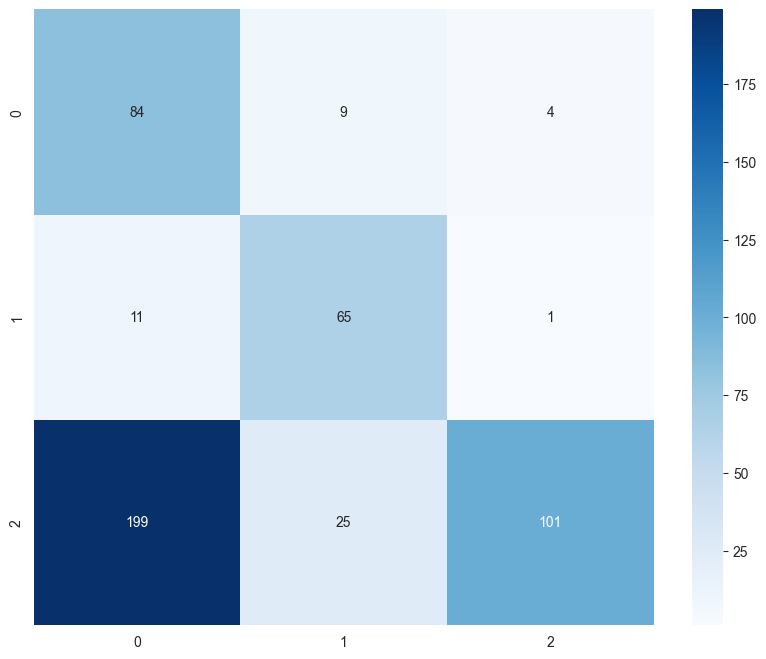

In [30]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test[target], y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()